In [15]:
from dateutil.parser import parse
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams.update({'figure.figsize':(10,7),'figure.dpi':120})

df=pd.read_csv('../Dollar-Carrot.csv')

In [16]:
df = df.reset_index()
df = df[['Date', 'Kandy']]
df = df.set_index('Date')


df = df.reset_index()
df

,Date,Kandy
0,2020-01-01,296.43
1,2020-01-02,267.86
2,2020-01-03,239.29
3,2020-01-04,210.71
4,2020-01-05,182.14
...,...,...
1454,2023-12-25,499.00
1455,2023-12-26,532.00
1456,2023-12-27,565.00
1457,2023-12-28,565.00


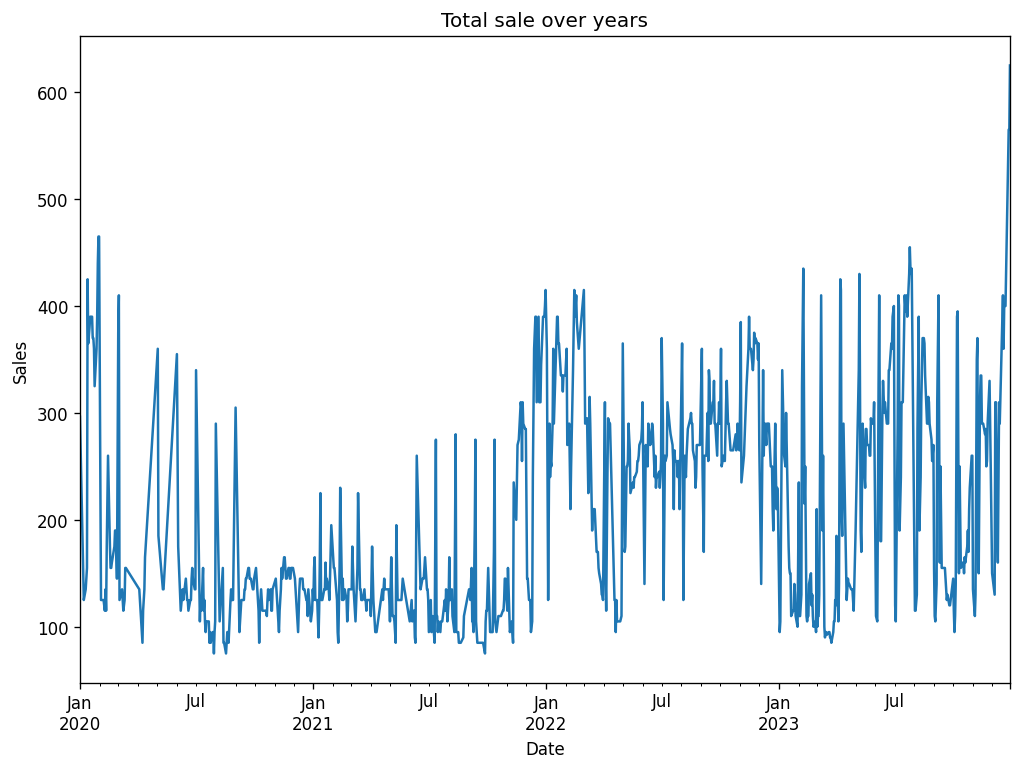

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df= df.set_index('Date')
df['Kandy'].plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Total sale over years')
plt.show()

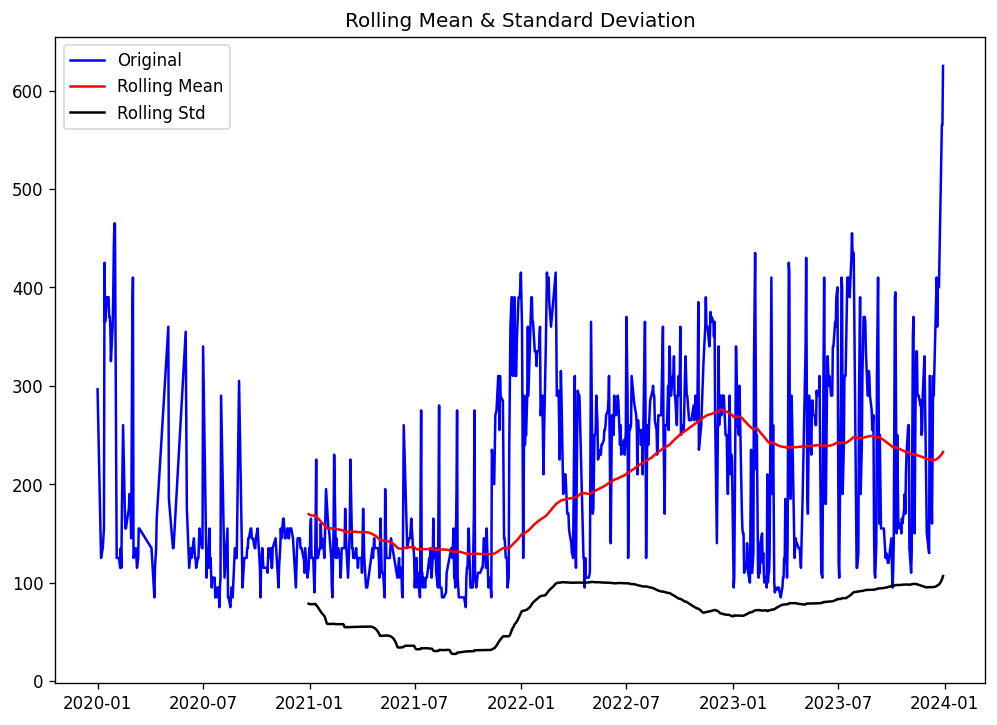

In [18]:

moving_avg = df.rolling(365).mean()
moving_std= df.rolling(365).std()
#Plot rolling statistics:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
std = plt.plot(moving_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [19]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -5.188615
p-value                           0.000009
#Lags Used                        6.000000
Number of Observations Used    1452.000000
Critical Value (1%)              -3.434862
Critical Value (5%)              -2.863533
Critical Value (10%)             -2.567831
dtype: float64


In [20]:
train_size = int(0.95 * len(df))

train = df[:train_size]
test = df[train_size:]

In [21]:
import pmdarima

from pmdarima import auto_arima
auto_arima(df,test='adf',       # use adftest to find optimal 'd'
                       # maximum p and q
                                 # frequency of series
                       # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=14760.661, Time=2.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=17430.887, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14862.401, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16096.604, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19958.384, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14803.208, Time=0.86 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=14803.301, Time=1.08 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=14758.955, Time=1.99 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=14756.805, Time=1.82 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=14790.622, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=14760.398, Time=2.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=14810.008, Time=0.18 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=14762.552, Time=1.42 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=14760.541, Time=2.32 sec
 ARIMA(3,0,1)(0,0,0

ARIMA(order=(3, 0, 1), scoring_args={}, suppress_warnings=True)

In [22]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train, order=(3,0,1)).fit()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [23]:
pred= model.predict(start=len(train), end=(len(df)-1),dynamic=True)
pred

2023-10-18    167.267808
2023-10-19    173.594846
2023-10-20    178.361587
2023-10-21    181.274838
2023-10-22    183.203711
                 ...    
2023-12-25    193.451132
2023-12-26    193.530500
2023-12-27    193.609057
2023-12-28    193.686810
2023-12-29    193.763768
Freq: D, Name: predicted_mean, Length: 73, dtype: float64

In [24]:
from  sklearn.metrics import mean_absolute_percentage_error

mape= mean_absolute_percentage_error(test, pred)

print('MAPE: %f' %mape)
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE directly using root_mean_squared_error
rmse = root_mean_squared_error(test, pred)

# Print the RMSE
print('RMSE: %f' % rmse)
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(test, pred)

# Print the MAE
print('MAE: %f' % mae)
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(test, pred))

# Print the RMSLE
print('RMSLE: %f' % rmsle)

MAPE: 0.343998
RMSE: 142.716523
MAE: 108.042523
RMSLE: 0.498723


In [25]:
test


,Kandy
Date,
2023-10-18,150.0
2023-10-19,165.0
2023-10-20,160.0
2023-10-21,165.0
2023-10-22,170.0
...,...
2023-12-25,499.0
2023-12-26,532.0
2023-12-27,565.0


In [26]:
pred

2023-10-18    167.267808
2023-10-19    173.594846
2023-10-20    178.361587
2023-10-21    181.274838
2023-10-22    183.203711
                 ...    
2023-12-25    193.451132
2023-12-26    193.530500
2023-12-27    193.609057
2023-12-28    193.686810
2023-12-29    193.763768
Freq: D, Name: predicted_mean, Length: 73, dtype: float64

<Axes: xlabel='Date'>

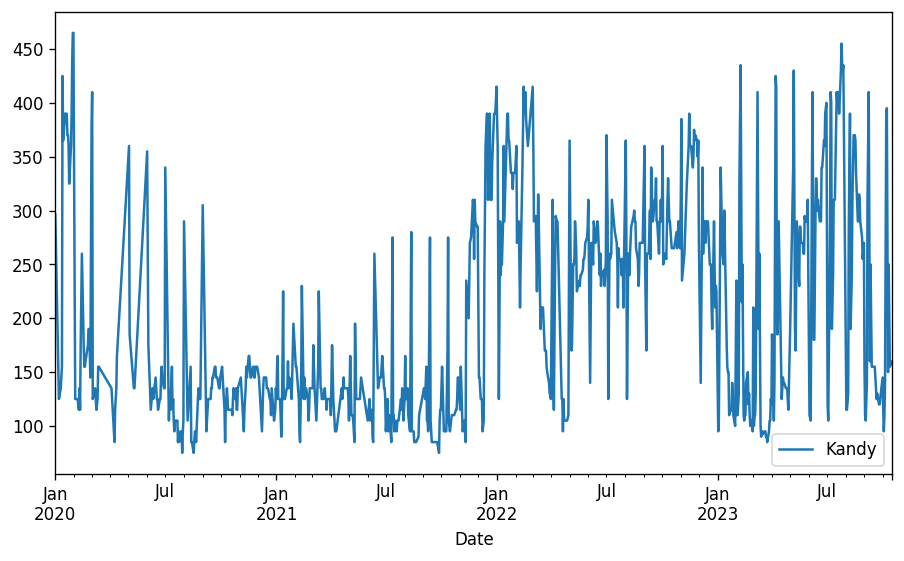

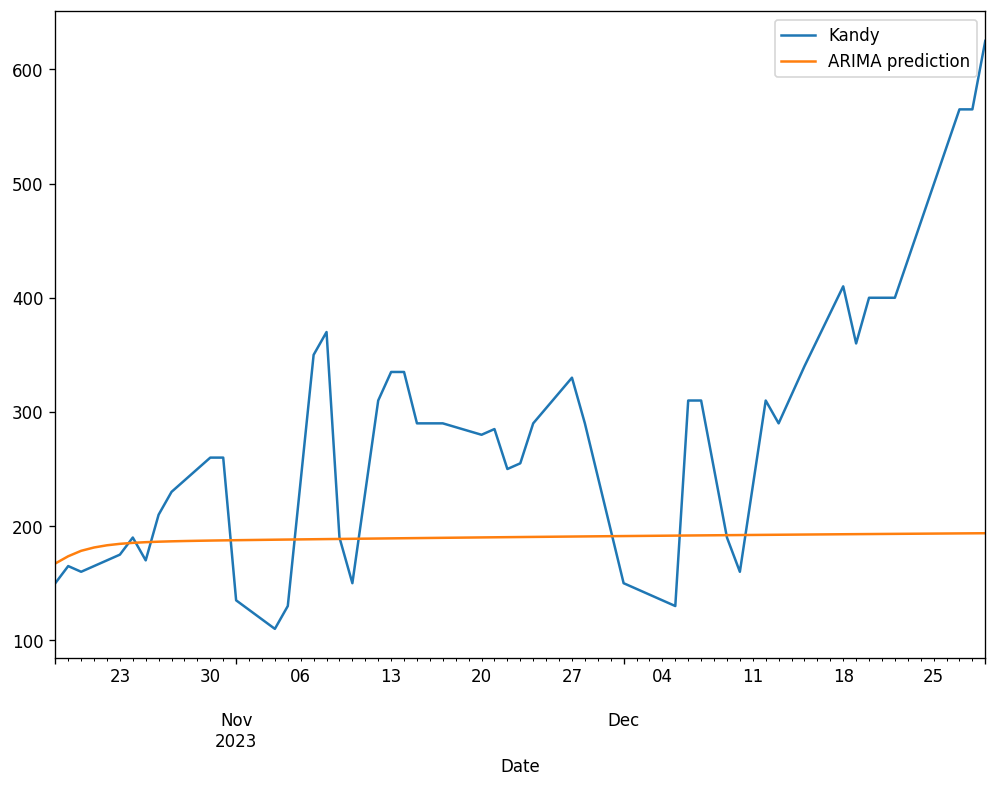

In [27]:
train.plot(legend=True, label='Train', figsize=(9,5))

test.plot(legend=True, label= 'Test')

pred.plot(legend=True, label='ARIMA prediction')